## Aplicação do RunnableConfig em situações mais práticas
___

### Estrutura básica do `RunnableConfig`

```python
RunnableConfig = TypedDict(
    "RunnableConfig",
    {
        "tags": list[str],           # tags para identificar runs
        "metadata": dict[str, Any],  # dados extras
        "configurable": dict[str, Any],  # parâmetros que você define
        "recursion_limit": int,      # profundidade máxima
        "run_name": str,             # nome do run
    },
    total=False,
)

```

**Exercício Prático: `Agente de Pesquisa Dinâmico`**

Vamos criar um grafo que não apenas altera o comportamento dentro de um nó, mas que muda sua rota de execução com base no config. Este agente receberá um tópico e, dependendo da configuração, usará uma ferramenta diferente (pesquisa na web ou consulta de banco de dados) para gerar um relatório personalizado.

Objetivo: Queremos construir um agente que recebe um tópico de pesquisa e, com base em uma configuração fornecida em tempo de execução, decide qual fonte de dados usar (ex: uma busca na web ou uma consulta em um banco de dados). Em seguida, ele deve gerar um relatório personalizado para um usuário específico, no idioma de sua preferência.

`Componentes da Arquitetura`

1. **Input**: recebe o estado inicial(tópico da pesquisa, nome do usuário)
2. **Router**: cérebro da operação. Ele inspeciona o objeto `config` para decidir qual ferramenta será usada. Este é o componente que torna o nosso grafo dinâmico
3. **Tools**:
    3.1. `web_search_tool`: Simula uma busca na internet
    3.2 `db_query_tool`: Simula uma consulta a um banco de dados
4. **Report Generator**: Pega os dados coletados por uma das ferramentas e formata um relatório final, usando informações do *estado* (nome do usuário) e do config(idioma)
5. **State**: A memória do nosso grafo, que carrega as informações (tópico, dados, mensagens) entre os passos.

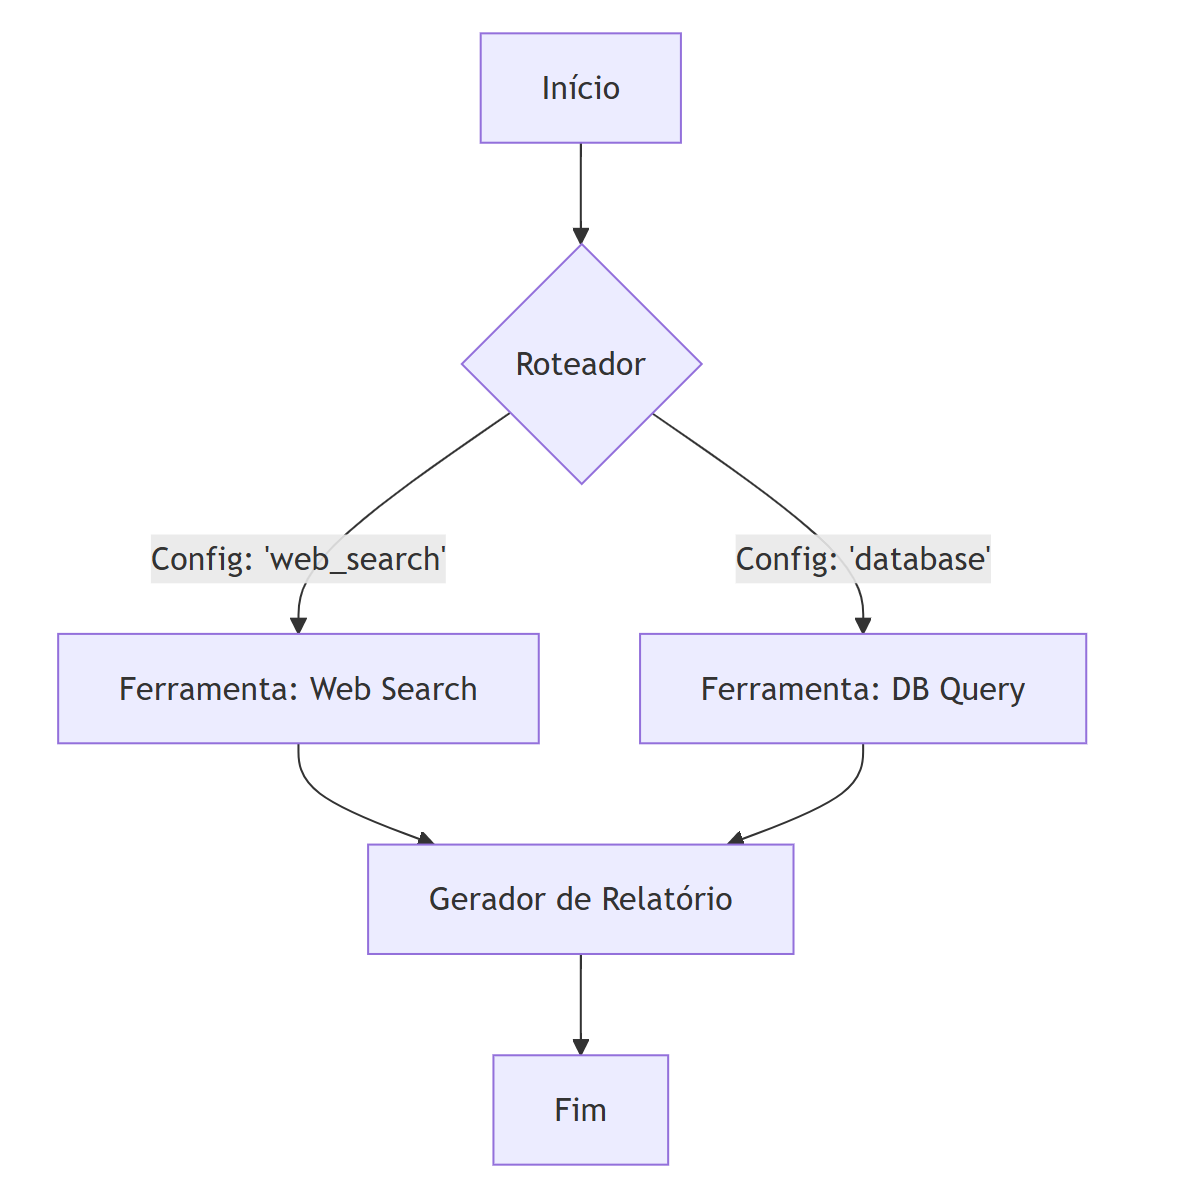

### Regras e Premissas
___

1. **Decisão Externa**: A escolha entre `web_search` e `db_query` não pode ser codificada no grafo. Ela deve ser determinada por um parâmetro (`tool_to_use`) passado via RunnableConfig.

2. **Personalização Externa**: O idioma do relatório final (`preferred_language`) também deve vir do RunnableConfig, tornando o nó de geração de relatório reutilizável.

3. **Estado Tipado**: O estado do grafo será definido usando TypedDict (a forma padrão do LangGraph, que se alinha com a filosofia de tipagem do Pydantic) para garantir clareza e segurança de tipos entre os nós.
    3a.Esquema de Estado com TypedDict: A estrutura principal do estado que flui através do grafo (AgentState) será definida usando TypedDict. Esta é a abordagem padrão e recomendada pelo LangGraph para garantir a verificação de tipos estática de forma eficiente.

    3.b Validação de Dados com Pydantic: A preferência por usar Pydantic será aplicada para validar os inputs ou outputs de nós específicos, caso eles manipulem dados complexos. Por exemplo, se uma ferramenta externa retornasse um JSON complexo, criaríamos um modelo Pydantic dentro do nó para parsear e validar aquele JSON antes de adicionar o resultado ao estado principal. (Para este exercício, como nossas ferramentas são simples, talvez não precisemos criar um modelo Pydantic, mas estabelecemos essa premissa arquitetural).

4. **Simulação**: As ferramentas (web_search e db_query) e o LLM do gerador de relatório serão simulados com funções Python simples. O foco é na estrutura do grafo e no fluxo de controle, não na implementação das ferramentas em si.

5. **Observabilidade**: Todas as etapas importantes do processo (decisão do roteador, execução da ferramenta) serão registradas com Loguru para facilitar o debug e o entendimento do fluxo. A execução completa será rastreada com LangSmith.

In [ ]:
# * 1. Importação das bibliotecas
import operator
import os
from typing import Annotated, TypedDict  # Adicionado TypedDict

from dotenv import find_dotenv, load_dotenv
from IPython.display import Image, display

# Importação essencial para acessar o objeto 'config' nos nós
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, START, StateGraph
from loguru import logger

# * 2. Configuração do ambiente
# Carrega variáveis de um arquivo .env no diretório raiz
_ = load_dotenv(find_dotenv())

In [ ]:
# * 3. Configuração do LangSmith (Opcional, mas recomendado)
# Garante que o LangSmith rastreie cada execução do nosso grafo
os.environ["LANGCHAIN_TRACING_V2"] = "true"
# Define o nome do projeto no LangSmith para organizar as execuções
os.environ["LANGCHAIN_PROJECT"] = "Exercício - Agente de Pesquisa Dinâmico"

# IMPORTANTE: Sua LANGCHAIN_API_KEY deve estar no seu arquivo .env

# * 4. Configuração do Logger
# Configura o loguru para salvar os logs em um arquivo, para análise posterior
logger.add(
    "output.log",
    rotation="10 MB",
    level="INFO",
    enqueue=True,
    format="{time} {level} {message}",
)
logger.info("Ambiente e bibliotecas carregados com sucesso.")

2025-09-19 19:41:42.805 | INFO     | __main__:<module>:18 - Ambiente e bibliotecas carregados com sucesso.


In [ ]:
class AgentState(TypedDict):
    """Represents the state of our dynamic research agent.

    This state is passed between all nodes in the graph. It holds the initial
    query, tracks the data retrieved by tools, and accumulates messages
    throughout the execution.

    Attributes:
        topic (str): The subject to be researched by the agent.
        user_name (str): The name of the user requesting the research, used for
            personalizing the final report.
        data (str): A field to store the raw data string retrieved by the
            chosen tool (either web search or database query).
        messages (Annotated[list[str], operator.add]): A list that accumulates
            messages, logs, or results from each step. The `operator.add`
            ensures that new messages are appended rather than replacing the
            entire list.

    """

    topic: str
    user_name: str
    data: str
    messages: Annotated[list[str], operator.add]

In [ ]:
def web_search_tool(state: AgentState) -> dict[str, str | list[str]]:
    """Simulate a web search tool to gather information on a topic.

    This node accesses the 'topic' from the state, simulates a web search,
    and returns the findings to be placed back into the state.

    Args:
        state (AgentState): The current state of the graph, which must contain
            the 'topic' to be searched.

    Returns:
        dict: A dictionary with keys to update the AgentState.
            - "data": The simulated string result from the web search.
            - "messages": A new log message to be appended to the state's message list.

    """
    topic = state["topic"]
    logger.info(f"Executando a ferramenta de busca na web para o tópico: '{topic}'")

    search_result = (
        f"Dados da web sobre '{topic}': LangGraph é uma biblioteca para construir "
        f"agentes robustos e com estado, estendendo os conceitos do LangChain."
    )

    return {"data": search_result, "messages": ["Resultado da busca na web coletado."]}

In [ ]:
def db_query_tool(state: AgentState) -> dict[str, str | list[str]]:
    """Simulate a database query tool to gather information on a topic.

    This node accesses the 'topic' from the state, simulates a database query,
    and returns the findings to be placed back into the state.

    Args:
        state (AgentState): The current state of the graph, which must contain
            the 'topic' to be queried.

    Returns:
        dict: A dictionary with keys to update the AgentState.
            - "data": The simulated string result from the database query.
            - "messages": A new log message to be appended to the state's message list.

    """
    topic = state["topic"]
    logger.info(f"Executando a ferramenta de banco de dados para o tópico: '{topic}'")

    db_result = (
        f"Dados do banco de dados sobre '{topic}': Tabela 'projects', "
        f"entrada 'LangGraph': status=ativo, time=agents, dependências=langchain-core."
    )

    return {"data": db_result, "messages": ["Resultado do banco de dados coletado."]}

-----

### **Etapa 5: Implementando o Roteador Dinâmico**

O roteador é uma função Python simples, mas seu papel é fundamental. Ele não modifica o estado. Sua única responsabilidade é inspecionar o objeto `config` (que é passado durante a chamada `.invoke()`) e retornar uma string que diz ao LangGraph qual nó executar em seguida.

#### **Explicação Detalhada dos Pontos-Chave:**

1.  **Assinatura da Função:** Note a diferença crucial aqui: `def router(state: AgentState, config: RunnableConfig) -> str:`. Pela primeira vez, estamos usando o segundo argumento, `config: RunnableConfig`. É assim que o LangGraph nos dá acesso aos parâmetros passados em tempo de execução.
2.  **Acesso à Configuração:** A linha `config.get("configurable", {}).get("tool_to_use")` é a mais importante.
      * O objeto `config` que recebemos tem uma estrutura específica. Os parâmetros que passamos ficam dentro de uma chave chamada `"configurable"`.
      * Usamos `.get("configurable", {})` como uma forma segura de obter o dicionário de configuração. Se ele não existir, recebemos um dicionário vazio `{}` em vez de um erro.
      * Em seguida, usamos `.get("tool_to_use")` para obter nossa chave de decisão.
3.  **Lógica Condicional:** O `if/elif/else` é direto. Ele simplesmente verifica o valor da preferência da ferramenta.
4.  **O Retorno Estratégico:** A string retornada por esta função é uma **instrução** para o LangGraph.
      * Se ela retornar `"web_search"`, o LangGraph irá executar o nó que registramos com o nome `"web_search"`.
      * Se retornar `"database"`, ele executará o nó `"database"`.
      * Se retornar `"end"`, ele irá para o nó especial `END`, finalizando a execução.

In [ ]:
def router(state: AgentState, config: RunnableConfig) -> str:
    """Decide qual ferramenta utilizar com base na configuração da execução.

    Este nó atua como um portão de entrada condicional. Ele lê a chave
    'tool_to_use' do objeto de configuração para determinar o próximo
    passo no grafo, utilizando um mapa de despacho para escalabilidade.

    Args:
        state (AgentState): O estado atual do grafo (não utilizado nesta função).
        config (RunnableConfig): O objeto de configuração da execução.

    Returns:
        str: O nome do próximo nó a ser executado ou "end" se a ferramenta
        não for encontrada ou especificada.

    """
    logger.info("Executando o roteador para decidir o próximo passo...")

    # Mapa de despacho: mapeia a preferência da ferramenta para o nome do nó.
    routing_map = {
        "web_search": "web_search",
        "database": "database",
    }

    tool_preference = config.get("configurable", {}).get("tool_to_use")

    # Usa o .get() do dicionário para encontrar o destino.
    # Se a chave não existir, ele retorna o valor padrão "end".
    destination = routing_map.get(tool_preference, "end")

    if destination == "end":
        logger.info(
            "Nenhuma rota válida encontrada na configuração. Terminando o fluxo."
        )
    else:
        logger.info(f"Decisão do roteador: seguir para o nó '{destination}'.")

    return destination

### 1\. O Papel do Roteador

**Sim, exatamente.** Você resumiu perfeitamente. O roteador ideal, na grande maioria dos casos, **não muda o estado**.

Sua única responsabilidade é atuar como um **controlador de tráfego**. Ele olha para os dados (seja o estado ou a configuração) e aponta a direção que o fluxo deve seguir. Pense nele como um operador de central telefônica: ele não altera a mensagem, apenas conecta a chamada ao ramal correto.

Essa separação de responsabilidades (Princípio da Responsabilidade Única) é o que torna a arquitetura do grafo tão poderosa:

  * **Nós de Ação:** Modificam o estado (ex: `web_search_tool`).
  * **Nós de Roteamento:** Direcionam o fluxo (ex: `router`).

#### **Por que esta versão é melhor?**

1.  **Mais Concisa e Legível:** A lógica de decisão principal é reduzida a uma única linha: `destination = routing_map.get(tool_preference, "end")`. A intenção do código fica muito mais clara.
2.  **Mais Escalável:** Esta é a grande vantagem. Se amanhã quisermos adicionar mais 5 ferramentas, não precisamos adicionar 5 novas cláusulas `elif`. Nós simplesmente adicionamos 5 novas entradas ao dicionário `routing_map`. O resto do código não muda. Isso é muito mais fácil de manter.
3.  **Menos Repetição (DRY - Don't Repeat Yourself):** Removemos a necessidade de ter múltiplos `logger.info` dentro da lógica condicional, centralizando o log da decisão no final.

####  `report_generator`.

Este nó é interessante porque ele utilizará informações de **duas fontes diferentes**:

1.  Do **estado (`state`)**, ele pegará os dados que a ferramenta coletou (`data`) e o nome do usuário (`user_name`).
2.  Do **config (`config`)**, ele pegará a preferência de idioma para gerar um relatório personalizado.

Isso demonstra perfeitamente o poder combinado do estado (para dados do fluxo) e da configuração (para parâmetros da execução).

-----

### **Etapa 4b: Implementando o Nó Gerador de Relatório**

#### **Explicação Detalhada:**

1.  **Extração de Dados do Estado:** As primeiras linhas da função coletam as informações que foram acumuladas durante o fluxo do grafo (`user_name`, `topic`, `data`).
2.  **Extração de Parâmetros da Configuração:** Em seguida, a função inspeciona o objeto `config` para um parâmetro específico daquela execução: `preferred_language`. Note que usamos `.get("preferred_language", "inglês")`, o que torna nosso nó mais **robusto**. Se o usuário não especificar um idioma, ele usará "inglês" como padrão em vez de gerar um erro.
3.  **Geração do Relatório:** Uma simples f-string formata todas as informações coletadas em uma saída amigável para o usuário.
4.  **Atualização do Estado:** O retorno `{"messages": [report]}` irá, graças à nossa configuração `Annotated` no `AgentState`, anexar este relatório final à lista de mensagens. Ao final da execução, o campo `messages` conterá os logs de cada ferramenta e o relatório completo.

-----

**Conseguimos\!** Neste ponto, temos todos os nossos blocos de construção prontos:

  * **A Estrutura de Dados:** `AgentState`
  * **As Ferramentas:** `web_search_tool` e `db_query_tool`
  * **A Lógica de Decisão:** `router`
  * **A Saída Final:** `report_generator`

In [ ]:
def report_generator(state: AgentState, config: RunnableConfig) -> dict[str, list[str]]:
    """Gera um relatório final baseado nos dados coletados e preferências do usuário.

    Este nó lê os dados coletados por uma ferramenta, o nome do usuário do estado,
    e o idioma preferencial da configuração de tempo de execução para criar um
    relatório personalizado e formatado.

    Args:
        state (AgentState): O estado atual do grafo, que deve conter
            'user_name', 'topic', e 'data'.
        config (RunnableConfig): O objeto de configuração da execução, que pode
            conter opcionalmente um 'preferred_language'. Padrão é 'inglês'.

    Returns:
        dict: Um dicionário com o relatório final para ser anexado à lista
            'messages' no AgentState.
    """
    logger.info("Gerando o relatório final...")

    # 1. Extrai os dados do estado
    user_name = state["user_name"]
    topic = state["topic"]
    data = state["data"]

    # 2. Extrai o idioma da configuração, com um valor padrão para robustez
    language = config.get("configurable", {}).get("preferred_language", "inglês")

    # 3. Gera o relatório final usando os dados de ambas as fontes
    report = (
        f"Olá, {user_name}!\n\n"
        f"Aqui está o seu relatório sobre '{topic}' (gerado em {language}):\n"
        f"---------------------------------------------------\n"
        f"{data}\n"
        f"---------------------------------------------------\n"
    )

    logger.info("Relatório final gerado com sucesso.")

    # 4. Retorna o relatório para ser adicionado à lista de mensagens do estado
    return {"messages": [report]}

### The Graph
___

In [ ]:
# --- Montagem do Grafo ---

logger.info("Iniciando a montagem do StateGraph...")

# 1. Instancia o workflow com a definição do nosso estado
workflow = StateGraph(AgentState)

# 2. Adiciona os nós de ação ao workflow, dando um nome a cada um
workflow.add_node("web_search", web_search_tool)
workflow.add_node("database", db_query_tool)
workflow.add_node("generate_report", report_generator)

# 3. Define o ponto de entrada condicional
# A partir do START, a função 'router' é chamada.
# O resultado da função 'router' (uma string) é usado como chave no dicionário
# para determinar o próximo nó.
workflow.add_conditional_edges(
    START,
    router,
    {
        "web_search": "web_search",
        "database": "database",
        "end": END,
    },
)

# 4. Define as arestas (ligações) fixas do workflow
workflow.add_edge("web_search", "generate_report")
workflow.add_edge("database", "generate_report")
workflow.add_edge("generate_report", END)

# 5. Compila o workflow em um objeto executável
graph = workflow.compile()
logger.info("Grafo compilado com sucesso.")


# --- Execução do Grafo ---

# Cenário 1: Execução com preferência para "web_search"
print("\n" + "=" * 50)
logger.info("INICIANDO CENÁRIO DE EXECUÇÃO 1: WEB SEARCH")
print("=" * 50)

# Define o estado inicial do grafo
inputs = {"topic": "LangGraph", "user_name": "Maria", "messages": []}

# Define a configuração para esta execução específica
config1 = {
    "configurable": {"tool_to_use": "web_search", "preferred_language": "português"}
}

# Invoca o grafo com o estado inicial e a configuração
result1 = graph.invoke(inputs, config=config1)

print("\n--- RELATÓRIO FINAL 1 ---")
print(result1["messages"][-1])
print("=" * 50 + "\n")


# Cenário 2: Execução com preferência para "database"
print("\n" + "=" * 50)
logger.info("INICIANDO CENÁRIO DE EXECUÇÃO 2: DATABASE")
print("=" * 50)

# A mesma entrada, mas uma configuração diferente
config2 = {"configurable": {"tool_to_use": "database", "preferred_language": "inglês"}}

result2 = graph.invoke(inputs, config=config2)

print("\n--- RELATÓRIO FINAL 2 ---")
print(result2["messages"][-1])
print("=" * 50 + "\n")

2025-09-19 20:42:53.711 | INFO     | __main__:<module>:3 - Iniciando a montagem do StateGraph...
2025-09-19 20:42:53.752 | INFO     | __main__:<module>:34 - Grafo compilado com sucesso.
2025-09-19 20:42:53.754 | INFO     | __main__:<module>:41 - INICIANDO CENÁRIO DE EXECUÇÃO 1: WEB SEARCH
2025-09-19 20:42:53.825 | INFO     | __main__:router:17 - Executando o roteador para decidir o próximo passo...
2025-09-19 20:42:53.826 | INFO     | __main__:router:36 - Decisão do roteador: seguir para o nó 'web_search'.
2025-09-19 20:42:53.828 | INFO     | __main__:web_search_tool:18 - Executando a ferramenta de busca na web para o tópico: 'LangGraph'
2025-09-19 20:42:53.830 | INFO     | __main__:report_generator:18 - Gerando o relatório final...
2025-09-19 20:42:53.830 | INFO     | __main__:report_generator:37 - Relatório final gerado com sucesso.
2025-09-19 20:42:53.832 | INFO     | __main__:<module>:62 - INICIANDO CENÁRIO DE EXECUÇÃO 2: DATABASE
2025-09-19 20:42:53.835 | INFO     | __main__:route



--- RELATÓRIO FINAL 1 ---
Olá, Maria!

Aqui está o seu relatório sobre 'LangGraph' (gerado em português):
---------------------------------------------------
Dados da web sobre 'LangGraph': LangGraph é uma biblioteca para construir agentes robustos e com estado, estendendo os conceitos do LangChain.
---------------------------------------------------




--- RELATÓRIO FINAL 2 ---
Olá, Maria!

Aqui está o seu relatório sobre 'LangGraph' (gerado em inglês):
---------------------------------------------------
Dados do banco de dados sobre 'LangGraph': Tabela 'projects', entrada 'LangGraph': status=ativo, time=agents, dependências=langchain-core.
---------------------------------------------------




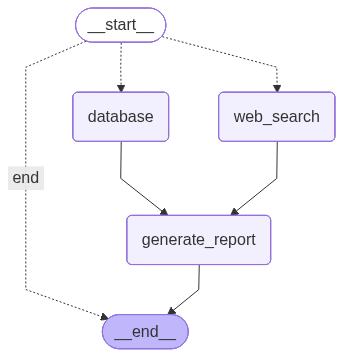

In [ ]:
# Opcional: Visualizar o grafo (requer 'pip install pygraphviz')
display(Image(graph.get_graph().draw_mermaid_png()))

# Resumo Didático: Conceitos e Arquitetura Aplicados

Este notebook foi um exercício prático para construir um "Agente de Pesquisa Dinâmico", indo além de cadeias lineares e explorando a capacidade do LangGraph de criar aplicações modulares e controláveis em tempo de execução. O objetivo foi demonstrar como o comportamento de um grafo pode ser alterado dinamicamente sem modificar seu código-fonte.

A seguir, um resumo dos principais conceitos e técnicas que aplicamos.

### 1. O Pilar Central: `RunnableConfig`

O `RunnableConfig` foi a peça-chave que permitiu a dinamicidade do nosso agente. Ele é um dicionário especial passado no momento da execução (`.invoke()`) que injeta parâmetros externos no fluxo do grafo. Utilizamos ele de duas maneiras cruciais:

-   **Para Controle de Fluxo (Roteamento):** No nó `router`, lemos a chave `tool_to_use` de dentro do `config`. Isso permitiu que o grafo tomasse um de dois caminhos completamente diferentes (`web_search` ou `database`), demonstrando a forma mais poderosa de controle externo.
-   **Para Parametrização de Nós:** No nó `report_generator`, lemos a chave `preferred_language` para alterar o texto do relatório final. Isso mostra como podemos ajustar o comportamento *interno* de um nó específico a cada execução.

### 2. Arquitetura do Grafo Orientado a Estado

Adotamos a arquitetura fundamental do LangGraph, que é baseada na manipulação de um objeto de estado compartilhado.

-   **O Estado (`AgentState`):**
    -   Definido com `TypedDict`, a abordagem padrão do LangGraph, que oferece segurança de tipo de forma leve e eficiente.
    -   Utilizamos o padrão `Annotated[list, operator.add]` para o campo `messages`. Esta é uma técnica essencial para **acumular** valores em uma lista (como um histórico de chat ou logs) em vez de sobrescrevê-los a cada passo.

-   **Os Nós (`Nodes`):**
    -   São funções Python simples e com **responsabilidade única** (buscar dados, gerar relatório).
    -   Seu contrato é claro: recebem o estado (`state`) como entrada e retornam um dicionário com as chaves do estado que desejam atualizar.

-   **O Roteador (`router`):**
    -   É um tipo especial de função cuja única responsabilidade é **direcionar o fluxo**. Ele não modifica o estado.
    -   Sua assinatura inclui o `config` para que possa tomar decisões com base em parâmetros externos.
    -   O retorno de uma string é uma **instrução** para o LangGraph sobre qual nó executar em seguida.

-   **As Arestas (`Edges`):**
    -   `add_edge`: Usada para criar transições **fixas e incondicionais** (ex: de uma ferramenta para o gerador de relatório).
    -   `add_conditional_edges`: O motor da nossa lógica dinâmica. Configuramos o grafo para, a partir do `START` (o ponto de partida conceitual), usar a função `router` para decidir o primeiro passo. Isso elimina a necessidade de um "nó de entrada" fixo e torna o grafo reativo desde o início.

### 3. Boas Práticas de Engenharia de Software

Além da lógica do agente, focamos em práticas que tornam o código mais robusto, legível e fácil de manter.

-   **Código Escalável:** Refatoramos o `router` de uma estrutura `if/elif/else` para um **mapa de despacho (dicionário)**. Isso torna a adição de novas ferramentas no futuro trivial (apenas uma nova entrada no dicionário), sem aumentar a complexidade do código.
-   **Observabilidade:** Configuramos `Loguru` para ter um registro claro e formatado de cada passo da execução, facilitando a depuração. A integração com `LangSmith` permite um rastreamento visual completo, mostrando o fluxo exato que foi tomado em cada execução, incluindo os inputs e outputs de cada nó.
-   **Documentação:** Utilizamos docstrings no padrão Google para explicar o propósito, os argumentos (`Args`) и os retornos (`Returns`) de cada função, criando um código auto-documentado.

### Conclusão

Este projeto serviu como uma síntese prática de como o LangGraph, combinado com boas práticas de engenharia, permite a criação de agentes complexos, modulares e configuráveis. A habilidade de controlar o fluxo e parametrizar nós em tempo de execução é a base para a construção de qualquer aplicação de IA mais sofisticada.